In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

In [176]:
# torch.set_num_threads(3)
torch.get_num_threads()

1

In [3]:
# import torch, torchvision, torchtext
# from torch import nn, cuda, backends, FloatTensor, LongTensor, optim
# import torch.nn.functional as F
# from torch.autograd import Variable
# from torch.utils.data import Dataset, TensorDataset

In [4]:
# torch.cuda.set_device(0)

# Generate Sine Wave

In [ ]:
np.random.seed(2)

T = 20
L = 1000
N = 100

In [ ]:
x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
x.shape

In [ ]:
data = np.sin(x / 1.0 / T).astype('float64')
torch.save(data, open('traindata.pt', 'wb'))
data.shape

In [ ]:
plt.plot(data[5,: ])

To use the data in the model, .chunk(train_input.size(1), dim=1) splits it into slices 1, 2, ..., t, ..., L.

## Model 

## Train and Test sets

In [ ]:
# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)

In [ ]:
# load data and make training set
data = torch.load('traindata.pt')

# Train dataset
train_input = torch.from_numpy(data[3:, :-1])
train_target = torch.from_numpy(data[3:, 1:])

# Test dataset
test_input = torch.from_numpy(data[:3, :-1])
test_target = torch.from_numpy(data[:3, 1:])

In [ ]:
data.shape

In [ ]:
plt.plot(train_input[96].numpy())

In [ ]:
print('Train input:', train_input.size(), ', Train target:', train_target.size())

In [ ]:
list(train_input.chunk(train_input.size(1), dim=1))[0].size()

## Build the model

In [ ]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [ ]:
# build the model
seq = Sequence()
seq.double()

In [ ]:
criterion = nn.MSELoss()

# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)

# optimizer = optim.Adam(seq.parameters(), lr=0.1, weight_decay=1e-3)

## Train

In [ ]:
#begin to train
for i in tqdm_notebook(range(20), desc='Epoch:'):
    
    def closure():
        optimizer.zero_grad()
        out = seq(train_input)
        loss = criterion(out, train_target)
        print('loss:', loss.item())
        loss.backward()
        return loss
    optimizer.step(closure)
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        future = 1000
        pred = seq(test_input, future=future)
        loss = criterion(pred[:, :-future], test_target)
        print('test loss:', loss.item())
        y = pred.detach().numpy()
    # draw the result
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)',
              fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    def draw(yi, color):
        plt.plot(np.arange(train_input.size(1)),
                 yi[:train_input.size(1)], color, linewidth = 2.0)
        plt.plot(np.arange(train_input.size(1), train_input.size(1) + future), 
                 yi[train_input.size(1):], color + ':', linewidth = 2.0)
    draw(y[0], 'r')
    draw(y[1], 'g')
    draw(y[2], 'b')
    plt.show()

# Trends and prices
Simulate price paths according to Dai, M., Zhang, Q., & Zhu, Q. J. (2010). Trend following trading under a regime switching model. SIAM Journal on Financial Mathematics, 1(1), 780-810.

In [5]:
import pandas as pd
from pandas import DataFrame, Series
pd.set_option('display.max_rows', 6)

In [22]:
def sim_path(N=1000, P=np.array([[0.95, 0.05], [0.1, 0.9]]),
             mu=[-0.05, 0.1], sigma=0.35, S0=1, dt=1/250):
    
    # State simulation
    state = np.random.randint(0, 2)
    states = [state]
    for t in range(N - 1):
        state = int(np.random.multinomial(1, P[state, :]).argmax())
        states.append(state)
    
    # Price simulation
    drift = (np.array([mu[s] for s in states[1:]]) - 0.5 * sigma**2) * dt
    wiener = np.random.randn(N - 1) * sigma * np.sqrt(dt)

    S = S0 * np.concatenate((np.ones(1), np.exp(np.cumsum(drift + wiener))))
    
    res_df = DataFrame(data=dict(Close=S, State=states))
    res_df = res_df.assign(Date = pd.date_range(start=datetime(2018, 1, 1),
                                                periods=N, freq='D')).set_index('Date')
    res_df = res_df.assign(Ch = res_df.Close.pct_change().add(1).apply('log'))
    res_df = res_df.assign(Ch2 = res_df.Ch.pow(2),
                           Ch3 = res_df.Ch.pow(3),
                           Ch4 = res_df.Ch.pow(4)).fillna(0)

    return res_df

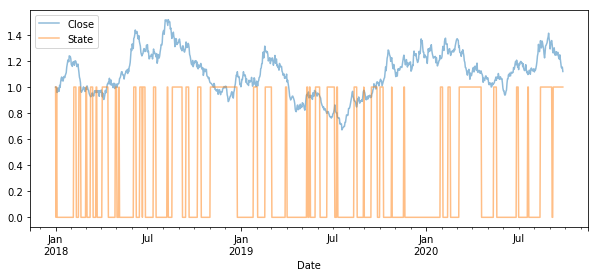

In [23]:
price_df = sim_path()
price_df[['Close', 'State']].plot(figsize=(10, 4), alpha = 0.5);

In [24]:
price_df

,Close,State,Ch,Ch2,Ch3,Ch4
Date,,,,,,
2018-01-01,1.000000,1,0.000000,0.000000,0.000000e+00,0.000000e+00
2018-01-02,0.998473,0,-0.001528,0.000002,-3.569463e-09,5.455113e-12
2018-01-03,0.990929,1,-0.007584,0.000058,-4.362425e-07,3.308547e-09
...,...,...,...,...,...,...
2020-09-24,1.145878,1,-0.005442,0.000030,-1.611890e-07,8.772306e-10
2020-09-25,1.153095,1,0.006278,0.000039,2.474225e-07,1.553289e-09
2020-09-26,1.119268,1,-0.029774,0.000887,-2.639526e-05,7.859013e-07


## Only Price
### Train and test sets
The input data for an LSTM cell in pytorch must be of dimension:

* `(seq_len, batch, input_size) = (seq_len, N_samples, 1)`.

In [ ]:
N_samples = 100

paths = [sim_path() for i in range(N_samples)]
inputs = np.array([p.Close.values for p in paths])
targets = np.array([p.State.values for p in paths])

In [ ]:
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

In [ ]:
inputs.size(), targets.size()

In [ ]:
list(inputs.chunk(inputs.size(1), dim=1))[0].size()

### Build the model 

In [ ]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        outputs = []
        h_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.sigmoid(self.linear(h_t2))
            outputs += [output]

        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [ ]:
# build the model
seq = Sequence()
seq.double()

In [ ]:
criterion = nn.CrossEntropyLoss()

# use LBFGS as optimizer since we can load the whole data to train
# optimizer = optim.LBFGS(seq.parameters(), lr=0.8)

optimizer = optim.Adam(seq.parameters())

In [ ]:
out = seq(inputs)
out

In [ ]:
out.view(-1, 2).size()

In [ ]:
targets.view(-1).size()

In [ ]:
out.size(), targets.size()

In [ ]:
criterion(out.view(-1, 2), targets.view(-1))

### Train

In [ ]:
#begin to train
for i in tqdm_notebook(range(20), desc='Epoch:'):
    
    def closure():
        optimizer.zero_grad()
        out = seq(inputs)
        loss = criterion(out.view(-1, 2), targets.view(-1))
        print('loss:', loss.item())
        loss.backward()
        return loss
    optimizer.step(closure)
    # begin to predict, no need to track gradient here
#     with torch.no_grad():
#         future = 1000
#         pred = seq(test_input, future=future)
#         loss = criterion(pred[:, :-future], test_target)
#         print('test loss:', loss.item())
#         y = pred.detach().numpy()

In [ ]:
outout = seq(inputs)
out

## Prices and changes 
### Train and test sets
The input data for an LSTM cell in pytorch must be of dimension:

* `(seq_len, batch, input_size) = (seq_len, N_samples, 5)`.

In [ ]:
N_samples = 100

paths = [sim_path() for i in range(N_samples)]
inputs = np.array([p.drop('State', axis=1).values for p in paths])
targets = np.array([p.State.values for p in paths])

In [ ]:
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

In [ ]:
inputs.size(), targets.size()

In [ ]:
list(inputs.chunk(inputs.size(1), dim=1))[0].view(N_samples, -1).size()

### Build the model

In [ ]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(5, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        outputs = []
        h_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t.view(N_samples, -1), (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.sigmoid(self.linear(h_t2))
            outputs += [output]

        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [ ]:
# build the model# build 
seq = Sequence()
seq.double()

In [ ]:
criterion = nn.CrossEntropyLoss()

# use LBFGS as optimizer since we can load the whole data to train
# optimizer = optim.LBFGS(seq.parameters(), lr=0.1)

optimizer = optim.Adam(seq.parameters())

In [ ]:
out = seq(inputs)
out

In [ ]:
out.size(), targets.size()

In [ ]:
out.view(-1, 2).size()

In [ ]:
targets.view(-1).size()

In [ ]:
criterion(out.view(-1, 2), targets.view(-1))

### Train

In [ ]:
#begin to train
for i in tqdm_notebook(range(20), desc='Epoch:'):
    
    def closure():
        optimizer.zero_grad()
        out = seq(inputs)
        loss = criterion(out.view(-1, 2), targets.view(-1))
        print('loss:', loss.item())
        loss.backward()
        return loss
    optimizer.step(closure)
    # begin to predict, no need to track gradient here
#     with torch.no_grad():
#         future = 1000
#         pred = seq(test_input, future=future)
#         loss = criterion(pred[:, :-future], test_target)
#         print('test loss:', loss.item())
#         y = pred.detach().numpy()

In [ ]:
out = seq(inputs)
out

# Support and Resistance

In [9]:
def add_support_resistance(df, fast=30, slow=120):
    return df.assign(Resistance_fast = df.Close.rolling(30).max(),
                     Resistance_slow = df.Close.rolling(120).max(),
                     Support_fast = df.Close.rolling(30).min(),
                     Support_slow = df.Close.rolling(120).min())

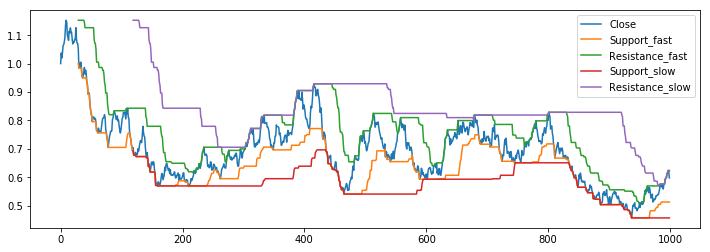

In [10]:
price_df = add_support_resistance(sim_path())

price_df[['Close', 'Support_fast', 'Resistance_fast',
          'Support_slow', 'Resistance_slow']].plot(figsize=(12, 4));

In [11]:
price_df

,Close,State,Ch,Ch2,Ch3,Ch4,Resistance_fast,Resistance_slow,Support_fast,Support_slow
0,1.000000,1,0.000000,0.000000,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
1,1.037318,1,0.036639,0.001342,4.918293e-05,1.801991e-06,NaN,NaN,NaN,NaN
2,1.019814,1,-0.017018,0.000290,-4.928860e-06,8.388069e-08,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
997,0.623371,1,0.012457,0.000155,1.932805e-06,2.407599e-08,0.623371,0.623371,0.512718,0.456728
998,0.621816,1,-0.002499,0.000006,-1.560078e-08,3.898178e-11,0.623371,0.623371,0.512718,0.456728
999,0.597411,1,-0.040038,0.001603,-6.418120e-05,2.569669e-06,0.623371,0.623371,0.512718,0.456728


## Train and test sets

In [12]:
N_samples = 100

input_variables = ['Close']
target_variables = ['Resistance_fast', 'Resistance_slow',
                    'Support_fast', 'Support_slow']

paths = [add_support_resistance(sim_path()) for i in range(N_samples)]
inputs = np.array([p[input_variables].values for p in paths], dtype=np.double)
targets = np.array([p[target_variables].values for p in paths], dtype=np.double)

In [13]:
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

In [14]:
inputs.size(), targets.size()

(torch.Size([100, 1000, 1]), torch.Size([100, 1000, 4]))

In [ ]:
# list(inputs.chunk(inputs.size(1), dim=1))[0].view(N_samples, -1).size()

## Build the model

In [37]:
class Sequence(nn.Module):
    def __init__(self, h0=1, h1=51, h2=51, hL=1):
        super(Sequence, self).__init__()
        self.h0 = h0
        self.h1 = h1
        self.h2 = h2
        self.hL = hL
        self.lstm1 = nn.LSTMCell(h0, h1)
        self.lstm2 = nn.LSTMCell(h1, h2)
        self.linear = nn.Linear(h2, hL)

    def forward(self, input):
        outputs = []
        h_t = torch.zeros(input.size(0), self.h1, dtype=torch.double)
        c_t = torch.zeros(input.size(0), self.h1, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), self.h2, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), self.h2, dtype=torch.double)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t.view(N_samples, -1), (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]

        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

    
class Sequence3(nn.Module):
    def __init__(self, h0=1, h1=10, h2=10, h3=10, hL=1):
        super(Sequence3, self).__init__()
        self.h0 = h0
        self.h1 = h1
        self.h2 = h2
        self.h3 = h3
        self.hL = hL
        self.lstm1 = nn.LSTMCell(h0, h1)
        self.lstm2 = nn.LSTMCell(h1, h2)
        self.lstm3 = nn.LSTMCell(h2, h3)
        self.linear = nn.Linear(h3, hL)

    def forward(self, input):
        outputs = []
        h_t = torch.zeros(input.size(0), self.h1, dtype=torch.double)
        c_t = torch.zeros(input.size(0), self.h1, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), self.h2, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), self.h2, dtype=torch.double)
        h_t3 = torch.ones(input.size(0), self.h3, dtype=torch.double)
        c_t3 = torch.zeros(input.size(0), self.h3, dtype=torch.double)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t.view(N_samples, -1), (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            h_t3, c_t3 = self.lstm3(h_t2, (h_t3, c_t3))
            output = self.linear(h_t3)
            outputs += [output]

        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

class Sequence4(nn.Module):
    def __init__(self, h0=1, h1=5, h2=5, h3=5, h4=5, hL=1):
        super(Sequence4, self).__init__()
        self.h0 = h0
        self.h1 = h1
        self.h2 = h2
        self.h3 = h3
        self.h4 = h4
        self.hL = hL
        self.lstm1 = nn.LSTMCell(h0, h1)
        self.lstm2 = nn.LSTMCell(h1, h2)
        self.lstm3 = nn.LSTMCell(h2, h3)
        self.lstm4 = nn.LSTMCell(h3, h4)
        self.linear = nn.Linear(h4, hL)

    def forward(self, input):
        outputs = []
        h_t = torch.zeros(input.size(0), self.h1, dtype=torch.double)
        c_t = torch.zeros(input.size(0), self.h1, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), self.h2, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), self.h2, dtype=torch.double)
        h_t3 = torch.ones(input.size(0), self.h3, dtype=torch.double)
        c_t3 = torch.zeros(input.size(0), self.h3, dtype=torch.double)
        h_t4 = torch.ones(input.size(0), self.h4, dtype=torch.double)
        c_t4 = torch.zeros(input.size(0), self.h4, dtype=torch.double)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t.view(N_samples, -1), (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            h_t3, c_t3 = self.lstm3(h_t2, (h_t3, c_t3))
            h_t4, c_t4 = self.lstm4(h_t3, (h_t4, c_t4))
            output = self.linear(h_t4)
            outputs += [output]

        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [31]:
# build the model
seq = Sequence4(hL=4)#Sequence(h0=1, h1=20, h2=10, hL=4)
seq.double()

Sequence4(
  (lstm1): LSTMCell(1, 5)
  (lstm2): LSTMCell(5, 5)
  (lstm3): LSTMCell(5, 5)
  (lstm4): LSTMCell(5, 5)
  (linear): Linear(in_features=5, out_features=4, bias=True)
)

In [32]:
mse = nn.MSELoss(reduce=False)
def criterion(y_hat, y_true):
    loss = mse(y_hat[:, 119:, :], y_true[:, 119:, :]).\
        div(y_true[:, 119:, :]).mean()
    return loss

In [33]:
out = seq(inputs)
out

tensor([[[ 0.1074,  0.1168,  0.1329,  0.4372],
         [ 0.0785,  0.1262,  0.1089,  0.4136],
         [ 0.0652,  0.1325,  0.0987,  0.4039],
         ...,
         [ 0.0409,  0.1392,  0.0887,  0.4006],
         [ 0.0409,  0.1392,  0.0887,  0.4006],
         [ 0.0409,  0.1392,  0.0887,  0.4006]],

        [[ 0.1074,  0.1168,  0.1329,  0.4372],
         [ 0.0785,  0.1262,  0.1089,  0.4136],
         [ 0.0652,  0.1325,  0.0987,  0.4039],
         ...,
         [ 0.0410,  0.1393,  0.0888,  0.4007],
         [ 0.0410,  0.1393,  0.0888,  0.4007],
         [ 0.0410,  0.1393,  0.0888,  0.4007]],

        [[ 0.1074,  0.1168,  0.1329,  0.4372],
         [ 0.0785,  0.1262,  0.1089,  0.4136],
         [ 0.0652,  0.1325,  0.0987,  0.4039],
         ...,
         [ 0.0400,  0.1387,  0.0882,  0.4001],
         [ 0.0400,  0.1387,  0.0882,  0.4001],
         [ 0.0400,  0.1387,  0.0882,  0.4001]],

        ...,

        [[ 0.1074,  0.1168,  0.1329,  0.4372],
         [ 0.0785,  0.1262,  0.1089,  0.4136]

In [34]:
out.size(), targets.size()

(torch.Size([100, 1000, 4]), torch.Size([100, 1000, 4]))

In [35]:
criterion(out, targets)

tensor(0.8206, dtype=torch.float64)

## Train

In [36]:
losses = []

In [80]:
optimizer = optim.Adam(seq.parameters(), lr=7e-5)

In [81]:
for i in tqdm_notebook(range(2500), desc='Epoch:'):
    
    def closure():
        optimizer.zero_grad()
        out = seq(inputs)
        loss = criterion(out, targets)
        losses.append(loss.detach().numpy())
        loss.backward()
        return loss
    optimizer.step(closure)
    
    if i % 10 == 0:
        print('i:', i, ', loss:', losses[-1])
    # begin to predict, no need to track gradient here
#     with torch.no_grad():
#         future = 1000
#         pred = seq(test_input, future=future)
#         loss = criterion(pred[:, :-future], test_target)
#         print('test loss:', loss.item())
#         y = pred.detach().numpy()

i: 0 , loss: 0.004424214091111001
i: 10 , loss: 0.004787197425403388
i: 20 , loss: 0.004636265204985733
i: 30 , loss: 0.004489289844777983
i: 40 , loss: 0.004435507850846919
i: 50 , loss: 0.0044189552503190385
i: 60 , loss: 0.004409819953812263
i: 70 , loss: 0.004402652246288815
i: 80 , loss: 0.004398267744551486
i: 90 , loss: 0.004394528600916309
i: 100 , loss: 0.004390412768950595
i: 110 , loss: 0.004386464202774011
i: 120 , loss: 0.0043824308715428115
i: 130 , loss: 0.004378365136534045
i: 140 , loss: 0.004374261475270767
i: 150 , loss: 0.004370115345379152
i: 160 , loss: 0.004365929458718344
i: 170 , loss: 0.004361706233831019
i: 180 , loss: 0.0043574479190183635
i: 190 , loss: 0.004353156789727205
i: 200 , loss: 0.00434883508532724
i: 210 , loss: 0.004344484952029976
i: 220 , loss: 0.004340108418110394
i: 230 , loss: 0.0043357073884747336
i: 240 , loss: 0.004331283648611308
i: 250 , loss: 0.004326838872380339
i: 260 , loss: 0.004322374630763671
i: 270 , loss: 0.004317892400920338


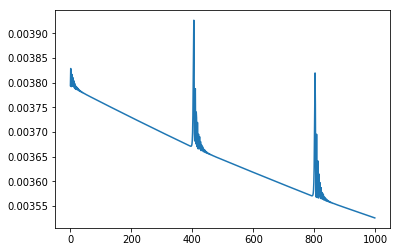

In [82]:
plt.plot(np.array(losses[-1000:]))

### Train sample

In [83]:
with torch.no_grad():
    out = seq(inputs)
out.size()

torch.Size([100, 1000, 4])

In [84]:
criterion(out, targets).item()

0.0035256351890231435

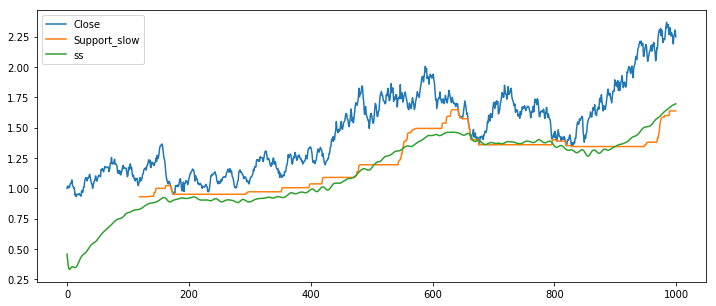

In [85]:
j = np.random.randint(0, N_samples)
y_hat = out.detach().numpy()
y_hat_df = DataFrame(data=y_hat[j,...], columns=['rf', 'rs', 'sf', 'ss'])
res_j = pd.concat((paths[j], y_hat_df), axis=1)
res_j[['Close', 'Support_slow', 'ss']].plot(figsize=(12, 5));

### Test sample

In [126]:
test_samples = 20

input_variables = ['Close']
target_variables = ['Resistance_fast', 'Resistance_slow',
                    'Support_fast', 'Support_slow']

test_paths = [add_support_resistance(sim_path(N=500)) for i in range(N_samples)]
test_inputs = np.array([p[input_variables].values for p in test_paths])
test_targets = np.array([p[target_variables].values for p in test_paths])

In [127]:
test_inputs = torch.from_numpy(test_inputs)
test_targets = torch.from_numpy(test_targets)

In [128]:
test_inputs.size()

torch.Size([100, 500, 1])

In [129]:
with torch.no_grad():
    test_out = seq(test_inputs)
test_out.size()

torch.Size([100, 500, 4])

In [130]:
criterion(test_out, test_targets).item()

0.003217763932008842

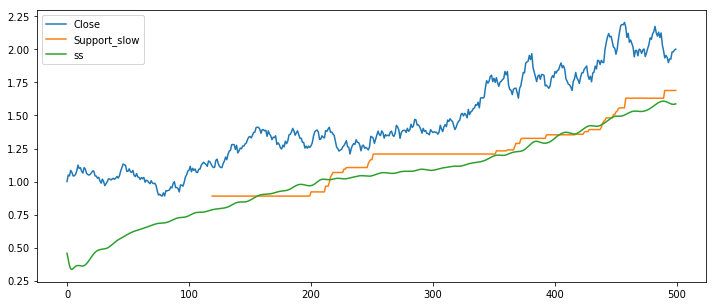

In [154]:
j = np.random.randint(0, test_samples)
y_hat = test_out.detach().numpy()
y_hat_df = DataFrame(data=y_hat[j,...], columns=['rf', 'rs', 'sf', 'ss'])
res_j = pd.concat((test_paths[j], y_hat_df), axis=1)
res_j[['Close', 'Support_slow', 'ss']].plot(figsize=(12, 5));

# Trend 

In [9]:
from trading_strategies import *
from utils import *

In [104]:
def add_trend(df, sd=20):
    df = df.assign(High=df.Close, Low=df.Close, Open=df.Close)
    df = find_trends(df, sd=sd)
    df.Trend = df.Trend.clip_lower(0)
    return df

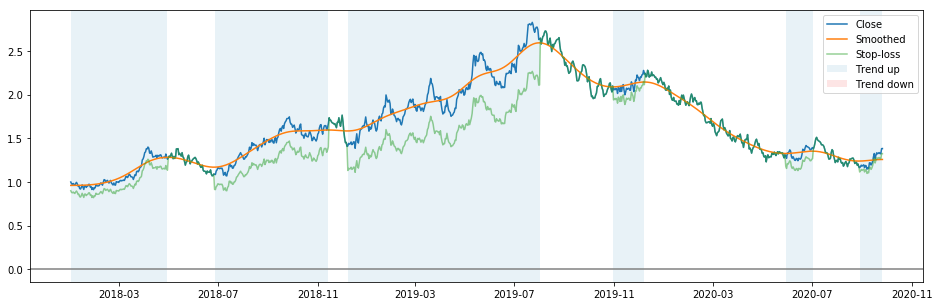

In [105]:
price_df = add_trend(sim_path())
plot_trends(price_df)

In [106]:
price_df

,Close,State,Ch,Ch2,Ch3,Ch4,High,Low,Open,Smoothed,...,n_Trend,Max_Drawdown,ATR,max_TR,min_TR,Ratio,ICAGR,Bliss,Trend_Start,Trend_End
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,1.000000,0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,1.000000,1.000000,0.961029,...,1.0,0.099747,0.015383,0.054279,0.0,1.260593,0.708856,7.106558,2018-01-01,2018-04-30
2018-01-02,0.977951,0,-0.022296,4.970959e-04,-1.108308e-05,2.471044e-07,0.977951,0.977951,0.977951,0.961046,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01,2018-04-30
2018-01-03,0.973856,0,-0.004196,1.760839e-05,-7.388892e-08,3.100552e-10,0.973856,0.973856,0.973856,0.961075,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01,2018-04-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-24,1.322403,1,-0.002266,5.135315e-06,-1.163726e-08,2.637147e-11,1.322403,1.322403,1.322403,1.257486,...,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-29,2020-09-26
2020-09-25,1.381714,1,0.043874,1.924944e-03,8.445537e-05,3.705411e-06,1.381714,1.381714,1.381714,1.257636,...,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-29,2020-09-26
2020-09-26,1.382645,1,0.000673,4.530327e-07,3.049259e-10,2.052386e-13,1.382645,1.382645,1.382645,1.257686,...,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-29,2020-09-26


## Train and test sets

In [164]:
N_samples = 250

In [165]:
input_variables = ['Close', 'Ch', 'Ch2', 'Ch3', 'Ch4', ]
target_variables = ['Trend']

paths = [add_trend(sim_path()) for i in range(N_samples)]
inputs = np.array([p[input_variables].values for p in paths], dtype=np.double)
targets = np.array([p[target_variables].values for p in paths], dtype=np.double)

//anaconda/envs/trend/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [166]:
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

In [167]:
inputs.size(), targets.size()

(torch.Size([250, 1000, 5]), torch.Size([250, 1000, 1]))

## Build the model

In [168]:
class Sequence(nn.Module):
    def __init__(self, h0=1, h1=51, h2=51, hL=1):
        super(Sequence, self).__init__()
        self.h0 = h0
        self.h1 = h1
        self.h2 = h2
        self.hL = hL
        self.lstm1 = nn.LSTMCell(h0, h1)
        self.lstm2 = nn.LSTMCell(h1, h2)
        self.linear = nn.Linear(h2, hL)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        outputs = []
        h_t = torch.zeros(input.size(0), self.h1, dtype=torch.double)
        c_t = torch.zeros(input.size(0), self.h1, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), self.h2, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), self.h2, dtype=torch.double)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t.view(N_samples, -1), (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.sigmoid(self.linear(h_t2))
            outputs += [output]

        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

    
class Sequence3(nn.Module):
    def __init__(self, h0=1, h1=10, h2=10, h3=10, hL=1):
        super(Sequence3, self).__init__()
        self.h0 = h0
        self.h1 = h1
        self.h2 = h2
        self.h3 = h3
        self.hL = hL
        self.lstm1 = nn.LSTMCell(h0, h1)
        self.lstm2 = nn.LSTMCell(h1, h2)
        self.lstm3 = nn.LSTMCell(h2, h3)
        self.linear = nn.Linear(h3, hL)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        outputs = []
        h_t = torch.zeros(input.size(0), self.h1, dtype=torch.double)
        c_t = torch.zeros(input.size(0), self.h1, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), self.h2, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), self.h2, dtype=torch.double)
        h_t3 = torch.ones(input.size(0), self.h3, dtype=torch.double)
        c_t3 = torch.zeros(input.size(0), self.h3, dtype=torch.double)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t.view(N_samples, -1), (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            h_t3, c_t3 = self.lstm3(h_t2, (h_t3, c_t3))
            output = self.sigmoid(self.linear(h_t3))
            outputs += [output]

        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

class Sequence4(nn.Module):
    def __init__(self, h0=1, h1=5, h2=5, h3=5, h4=5, hL=1):
        super(Sequence4, self).__init__()
        self.h0 = h0
        self.h1 = h1
        self.h2 = h2
        self.h3 = h3
        self.h4 = h4
        self.hL = hL
        self.lstm1 = nn.LSTMCell(h0, h1)
        self.lstm2 = nn.LSTMCell(h1, h2)
        self.lstm3 = nn.LSTMCell(h2, h3)
        self.lstm4 = nn.LSTMCell(h3, h4)
        self.linear = nn.Linear(h4, hL)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        outputs = []
        h_t = torch.zeros(input.size(0), self.h1, dtype=torch.double)
        c_t = torch.zeros(input.size(0), self.h1, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), self.h2, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), self.h2, dtype=torch.double)
        h_t3 = torch.ones(input.size(0), self.h3, dtype=torch.double)
        c_t3 = torch.zeros(input.size(0), self.h3, dtype=torch.double)
        h_t4 = torch.ones(input.size(0), self.h4, dtype=torch.double)
        c_t4 = torch.zeros(input.size(0), self.h4, dtype=torch.double)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t.view(N_samples, -1), (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            h_t3, c_t3 = self.lstm3(h_t2, (h_t3, c_t3))
            h_t4, c_t4 = self.lstm4(h_t3, (h_t4, c_t4))
            output = self.sigmoid(self.linear(h_t4))
            outputs += [output]

        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [311]:
# build the model
seq = Sequence4(h0=5, hL=1)#, h1=10, h2=8, h3=6, h4=3)
seq.double()

Sequence4(
  (lstm1): LSTMCell(5, 10)
  (lstm2): LSTMCell(10, 8)
  (lstm3): LSTMCell(8, 6)
  (lstm4): LSTMCell(6, 3)
  (linear): Linear(in_features=3, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [312]:
out = seq(inputs)
out

tensor([[ 0.5114,  0.5249,  0.5345,  ...,  0.5510,  0.5510,  0.5510],
        [ 0.5114,  0.5249,  0.5345,  ...,  0.5510,  0.5510,  0.5510],
        [ 0.5114,  0.5249,  0.5345,  ...,  0.5511,  0.5511,  0.5511],
        ...,
        [ 0.5114,  0.5249,  0.5345,  ...,  0.5510,  0.5510,  0.5510],
        [ 0.5114,  0.5249,  0.5344,  ...,  0.5513,  0.5513,  0.5513],
        [ 0.5114,  0.5249,  0.5344,  ...,  0.5514,  0.5514,  0.5514]], dtype=torch.float64)

In [313]:
out.unsqueeze(2).size(), targets.size()

(torch.Size([250, 1000, 1]), torch.Size([250, 1000, 1]))

In [314]:
warmup = 60

def loss_fun(y_hat, y_true):
    return torch.mean(- y_true * y_hat.log() - \
              (1 - y_true) * (1 - y_hat).log())

def criterion(y_hat, y_true, warmup=90):
    loss = loss_fun(y_hat[:, warmup:, :], y_true[:, warmup:, :])
    return loss

In [315]:
criterion(out.unsqueeze(2), targets)

tensor(0.7026, dtype=torch.float64)

## Train

In [316]:
losses = []

In [317]:
optimizer = optim.Adam(seq.parameters(), lr=1e-3)

In [318]:
for i in tqdm_notebook(range(100), desc='Epoch:'):
    
    def closure():
        optimizer.zero_grad()
        out = seq(inputs).unsqueeze(2)
        loss = criterion(out, targets)
        losses.append(loss.detach().numpy())
        loss.backward()
        return loss
    optimizer.step(closure)
    
    if i % 10 == 0:
        print('i: ', i, ', loss: ', losses[-1], sep='')
    # begin to predict, no need to track gradient here
#     with torch.no_grad():
#         future = 1000
#         pred = seq(test_input, future=future)
#         loss = criterion(pred[:, :-future], test_target)
#         print('test loss:', loss.item())
#         y = pred.detach().numpy()

i: 0, loss: 0.702645611075114
i: 10, loss: 0.6998326157805203
i: 20, loss: 0.6978161202435127
i: 30, loss: 0.6963034380026866
i: 40, loss: 0.6951094182822954
i: 50, loss: 0.694120791593022
i: 60, loss: 0.693296499740528
i: 70, loss: 0.6926717765562647
i: 80, loss: 0.6923192555495269
i: 90, loss: 0.692218156830637



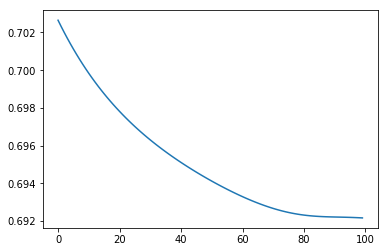

In [319]:
plt.plot(np.array(losses))

### Train sample

In [320]:
from sklearn.metrics import confusion_matrix

In [321]:
with torch.no_grad():
    out = seq(inputs)
out.size()

torch.Size([250, 1000])

In [322]:
criterion(out.unsqueeze(dim=2), targets).item()

0.6921608333508854

In [323]:
y_true = targets[:, warmup:, :].numpy()
y_pred = out.unsqueeze(dim=2)[:, warmup:, :].detach().numpy().copy()
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0

In [324]:
confusion_matrix(y_true.flatten(), y_pred.flatten()) / len(y_true.flatten())

array([[0.52185106, 0.        ],
       [0.47814894, 0.        ]])

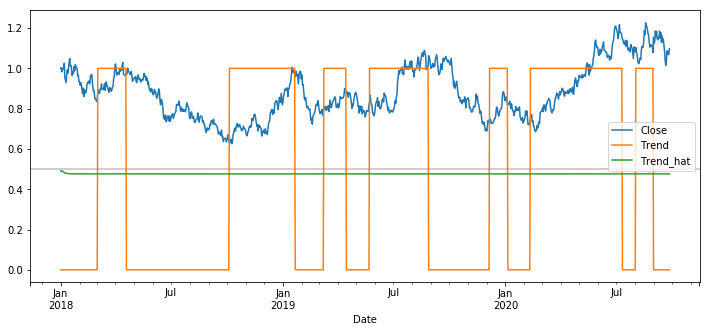

In [325]:
j = np.random.randint(0, N_samples)
y_hat = out.detach().numpy()

# y_hat_df = DataFrame(data=y_hat[j,...], columns='Trend')
res_j = paths[j].assign(Trend_hat=y_hat[j,...])
res_j[['Close', 'Trend', 'Trend_hat']].plot(figsize=(12, 5))
plt.axhline(0.5, c='grey', alpha=0.5);

### Test sample

In [326]:
# N_samples = 20
test_paths = [add_trend(sim_path(N=500)) for i in range(N_samples)]
test_inputs = np.array([p[input_variables].values for p in test_paths])
test_targets = np.array([p[target_variables].values for p in test_paths])

In [327]:
test_inputs = torch.from_numpy(test_inputs)
test_targets = torch.from_numpy(test_targets)

In [328]:
test_inputs.size()

torch.Size([250, 500, 5])

In [329]:
with torch.no_grad():
    test_out = seq(test_inputs)
test_out.size()

torch.Size([250, 500])

In [330]:
criterion(test_out.unsqueeze(dim=2), test_targets).item()

0.6918954147368108

In [331]:
y_true = test_targets[:, warmup:, :].numpy()
y_pred = test_out.unsqueeze(dim=2)[:, warmup:, :].detach().numpy().copy()
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0

In [332]:
confusion_matrix(y_true.flatten(), y_pred.flatten()) / len(y_true.flatten())

array([[0.5227, 0.    ],
       [0.4773, 0.    ]])

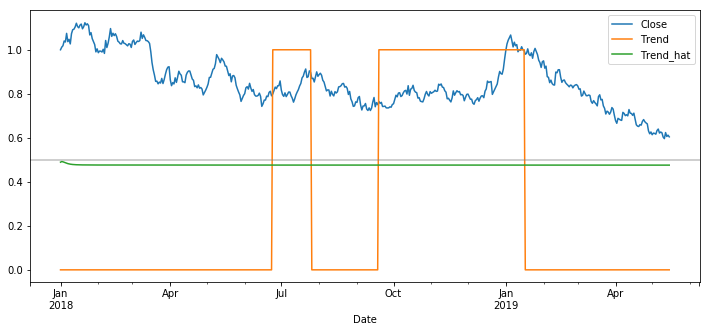

In [333]:
j = np.random.randint(0, N_samples)
y_hat = test_out.detach().numpy()

# y_hat_df = DataFrame(data=y_hat[j,...], columns='Trend')
res_j = test_paths[j].assign(Trend_hat=y_hat[j,...])
res_j[['Close', 'Trend', 'Trend_hat']].plot(figsize=(12, 5))
plt.axhline(0.5, c='grey', alpha=0.5);

# End